In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

In [13]:
df = pd.read_csv("movie_dataset_cleaned.csv")
df.head()

,id,title,rating,release_date,adult,imdb_id,overview,genres
0,27205,Inception,8.364,2010-07-15,False,tt1375666,"Cobb, a skilled thief who commits corporate es...","Action, Sci-Fi, Adventure"
1,157336,Interstellar,8.417,2014-11-05,False,tt0816692,The adventures of a group of explorers who mak...,"Adventure, Drama, Sci-Fi"
2,155,The Dark Knight,8.512,2008-07-16,False,tt0468569,Batman raises the stakes in his war on crime. ...,"Drama, Action, Crime, Thriller"
3,19995,Avatar,7.573,2009-12-15,False,tt0499549,"In the 22nd century, a paraplegic Marine is di...","Action, Adventure, Fantasy, Sci-Fi"
4,24428,The Avengers,7.710,2012-04-25,False,tt0848228,When an unexpected enemy emerges and threatens...,"Sci-Fi, Action, Adventure"


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1357682 entries, 0 to 1357681
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            1357682 non-null  int64  
 1   title         1357682 non-null  object 
 2   rating        1357682 non-null  float64
 3   release_date  1072722 non-null  object 
 4   adult         1357682 non-null  bool   
 5   imdb_id       654026 non-null   object 
 6   overview      1051316 non-null  object 
 7   genres        770910 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(5)
memory usage: 73.8+ MB


In [15]:
df.isnull().sum()

id                   0
title                0
rating               0
release_date    284960
adult                0
imdb_id         703656
overview        306366
genres          586772
dtype: int64

In [16]:
df.describe()

,id,rating
count,1.357682e+06,1.357682e+06
mean,8.650819e+05,1.615004e+00
std,4.599150e+05,2.891556e+00
min,2.000000e+00,0.000000e+00
25%,4.767372e+05,0.000000e+00
50%,8.806540e+05,0.000000e+00
75%,1.270187e+06,2.000000e+00
max,1.620905e+06,1.000000e+01


In [17]:
df['genre_content'] = df['genres'].str.replace(',', ' ', regex=False)

df['genre_content'] = df['genre_content'].fillna("")

In [18]:
tfidf = TfidfVectorizer()

tfidf_matrix = tfidf.fit_transform(df['genre_content'])

In [19]:
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

In [20]:
def recommend_movies(movie_title, top_n=10, min_similarity=0.1, sim_weight=0.7, rating_weight=0.3):
    if movie_title not in indices:
        return f"Movie '{movie_title}' not found in dataset"
    
    idx = indices[movie_title]
    if isinstance(idx, (list, pd.Series, np.ndarray)):
        idx = int(idx.iloc[0])
    else:
        idx = int(idx)
    
    similarity_scores = linear_kernel(tfidf_matrix[idx:idx+1], tfidf_matrix).flatten()
    similarity_scores[idx] = 0
    
    temp_df = df.assign(similarity=similarity_scores)
    temp_df = temp_df[temp_df['similarity'] >= min_similarity]
    
    temp_df['rating'] = temp_df['rating'].fillna(temp_df['rating'].mean())
    temp_df['normalized_rating'] = temp_df['rating'] / 10.0
    
    temp_df['weighted_score'] = (sim_weight * temp_df['similarity']) + (rating_weight * temp_df['normalized_rating'])
    
    result = temp_df[['title', 'genres', 'rating', 'similarity', 'weighted_score', 'release_date']] \
                .sort_values(by='weighted_score', ascending=False) \
                .head(top_n).copy()
    
    result['release_date'] = result['release_date'].fillna('Unknown')
    result['similarity'] = result['similarity'].round(3)
    result['weighted_score'] = result['weighted_score'].round(3)
    
    return result


In [21]:
recommend_movies("The Avengers", 10)

,title,genres,rating,similarity,weighted_score,release_date
344924,Himitsu Sentai Gorenger: The Blue Fortress,"Sci-Fi, Action, Adventure",10.0,1.0,1.0,1975-07-26
344914,Himitsu Sentai Gorenger: The Red Death Match,"Sci-Fi, Action, Adventure",10.0,1.0,1.0,1976-01-10
263203,The Traveler,"Action, Adventure, Sci-Fi",10.0,1.0,1.0,2019-11-12
307932,Kamen Rider Kuuga: Special Edition,"Action, Adventure, Sci-Fi",10.0,1.0,1.0,2001-10-21
231663,Blood and Steel,"Sci-Fi, Action, Adventure",10.0,1.0,1.0,2015-06-01
306574,Ultra Fight Victory,"Action, Adventure, Sci-Fi",10.0,1.0,1.0,2016-07-05
250020,Laser Cats,"Sci-Fi, Action, Adventure",10.0,1.0,1.0,2023-04-28
230477,The Legend of Space Sheriff Gavan,"Action, Adventure, Sci-Fi",10.0,1.0,1.0,2012-10-20
226212,Coal Miner's Adventure,"Action, Adventure, Sci-Fi",10.0,1.0,1.0,Unknown
247664,The Gunner,"Action, Adventure, Sci-Fi",10.0,1.0,1.0,2015-11-01


Rating Distribution

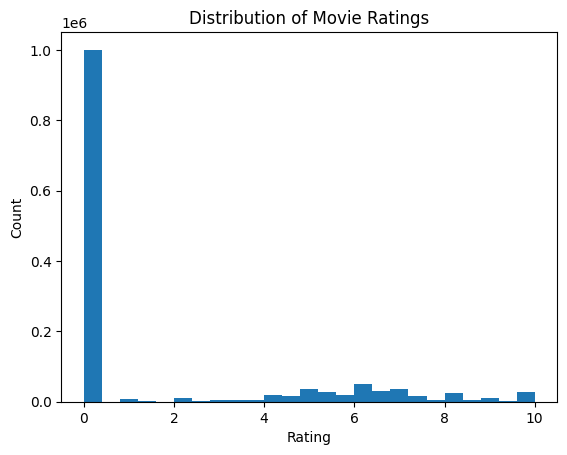

In [22]:
plt.hist(df['rating'], bins=25)
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Top Genres Frequency

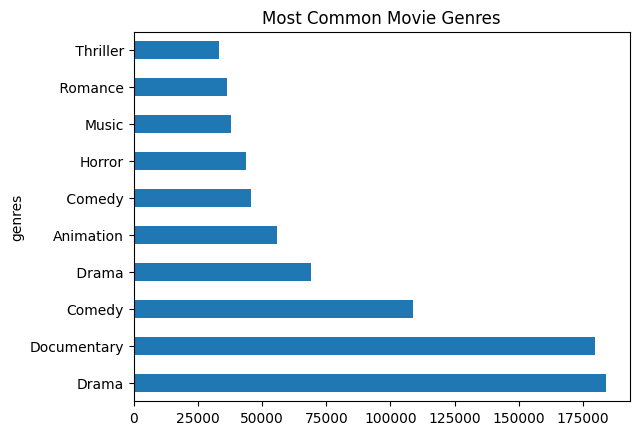

In [23]:
df['genres'].str.split(',').explode().value_counts().head(10).plot(kind='barh')
plt.title("Most Common Movie Genres")
plt.show()

Recommendation Result Visualization

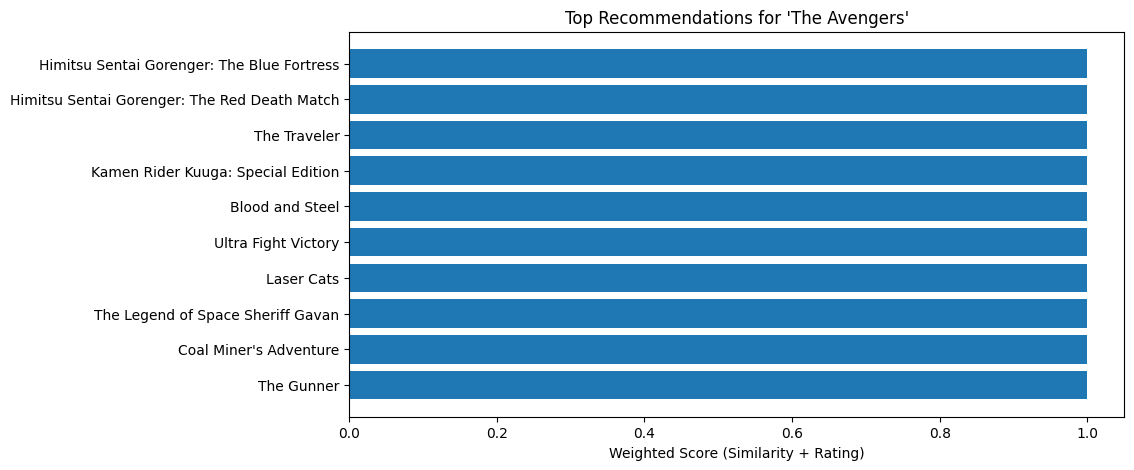

In [24]:
movie_name = "The Avengers"
result = recommend_movies(movie_name, top_n=10)

plt.figure(figsize=(10,5))
plt.barh(result['title'], result['weighted_score'])
plt.xlabel("Weighted Score (Similarity + Rating)")
plt.title(f"Top Recommendations for '{movie_name}'")
plt.gca().invert_yaxis()
plt.show()

Stacked Contribution Plot

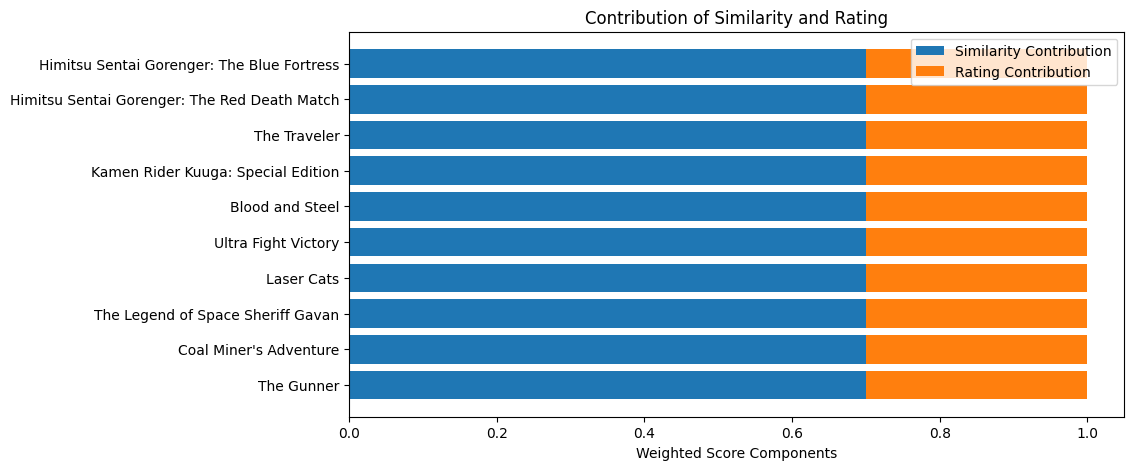

In [25]:
sim_weight = 0.7
rating_weight = 0.3

sim_part = sim_weight * result['similarity']
rating_part = rating_weight * (result['rating'] / 10.0)

plt.figure(figsize=(10,5))
plt.barh(result['title'], sim_part, label='Similarity Contribution')
plt.barh(result['title'], rating_part, left=sim_part, label='Rating Contribution')

plt.xlabel("Weighted Score Components")
plt.title("Contribution of Similarity and Rating")
plt.legend()
plt.gca().invert_yaxis()
plt.show()